In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Load the data
file_path = '../data/vfv_raw_data.csv'
vfv_data = pd.read_csv(file_path)

# Quick look at the data
vfv_data.head()

,Date,NAV (CAD),Market price (CAD)
0,Mar 07 2025,$147.2612,$147.3700
1,Mar 06 2025,$145.8448,$145.8100
2,Mar 05 2025,$148.8868,$148.8000
3,Mar 04 2025,$148.5961,$148.6000
4,Mar 03 2025,$150.7359,$150.7000


In [193]:
vfv_data['Date'] = pd.to_datetime(vfv_data['Date'])
vfv_data.set_index('Date', inplace=True)

# Clean data
vfv_data.dropna(inplace=True)

vfv_data.rename(columns={'Market price (CAD)': 'Close'}, inplace=True)
vfv_data

,NAV (CAD),Close
Date,,
2025-03-07,$147.2612,$147.3700
2025-03-06,$145.8448,$145.8100
2025-03-05,$148.8868,$148.8000
2025-03-04,$148.5961,$148.6000
2025-03-03,$150.7359,$150.7000
...,...,...
2014-11-24,$41.5520,$41.5650
2014-11-21,$41.2651,$41.2450
2014-11-20,$41.2772,$41.2850


In [194]:
# Check data types
vfv_data.dtypes

NAV (CAD)    object
Close        object
dtype: object

In [195]:
# Convert 'Close' to float
vfv_data['Close'] = vfv_data['Close'].replace('[\$,]', '', regex=True).astype(float)
vfv_data
print(vfv_data.dtypes)

NAV (CAD)     object
Close        float64
dtype: object


<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/var/folders/d_/vtbtm_tx56jbs30plxf7r3mh0000gn/T/ipykernel_67693/4184970370.py:2: SyntaxWarning: invalid escape sequence '\$'
  vfv_data['Close'] = vfv_data['Close'].replace('[\$,]', '', regex=True).astype(float)


In [196]:
# Fetch CAD to USD exchange rate from Yahoo Finance
cad_usd = yf.download('CADUSD=X', start=vfv_data.index.min(), end=vfv_data.index.max())
cad_usd = cad_usd.reset_index().set_index('Date')
cad_usd

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,CADUSD=X,CADUSD=X,CADUSD=X,CADUSD=X,CADUSD=X
Date,,,,,
2014-11-18,0.885347,0.888336,0.883314,0.885269,0
2014-11-19,0.883252,0.883704,0.880669,0.883548,0
2014-11-20,0.881135,0.885269,0.879631,0.881135,0
2014-11-21,0.884251,0.893072,0.883018,0.884251,0
2014-11-24,0.890456,0.891107,0.886462,0.890345,0
...,...,...,...,...,...
2025-03-03,0.692473,0.695488,0.691931,0.692473,0
2025-03-04,0.690131,0.694126,0.688866,0.690131,0


In [197]:
cad_usd.columns

MultiIndex([( 'Close', 'CADUSD=X'),
            (  'High', 'CADUSD=X'),
            (   'Low', 'CADUSD=X'),
            (  'Open', 'CADUSD=X'),
            ('Volume', 'CADUSD=X')],
           names=['Price', 'Ticker'])

In [198]:
# Flatten multi-level columns
if isinstance(cad_usd.columns, pd.MultiIndex):
    cad_usd.columns = cad_usd.columns.get_level_values(0)
    
cad_usd.columns 

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [199]:
# Merge exchange rate data with VFV data
vfv_data = vfv_data.join(cad_usd[['Close']].rename(columns={'Close': 'CADUSD'}), how='left')
vfv_data

,NAV (CAD),Close,CADUSD
Date,,,
2025-03-07,$147.2612,147.370,0.699736
2025-03-06,$145.8448,145.810,0.697418
2025-03-05,$148.8868,148.800,0.694584
2025-03-04,$148.5961,148.600,0.690131
2025-03-03,$150.7359,150.700,0.692473
...,...,...,...
2014-11-24,$41.5520,41.565,0.890456
2014-11-21,$41.2651,41.245,0.884251
2014-11-20,$41.2772,41.285,0.881135


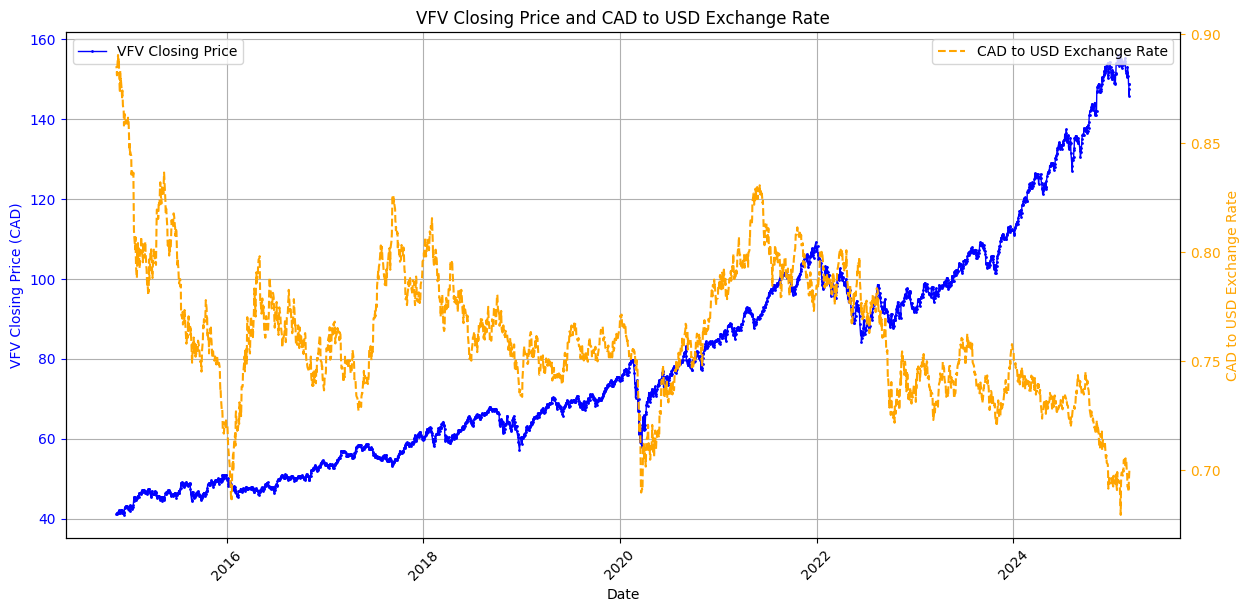

In [200]:
# Visualize closing price and exchange rate
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot VFV closing price with larger, clearer markers and a thicker line
ax1.plot(vfv_data.index, vfv_data['Close'], color='blue', label='VFV Closing Price', linewidth=1, marker='o', markersize=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('VFV Closing Price (CAD)', color='blue')
ax1.tick_params(axis='y', colors='blue', labelsize=10)  # Adjusting y-axis label size
ax1.grid(True)

# Rotate date labels and fix spacing
plt.xticks(rotation=45)
plt.tight_layout()

# Add second y-axis for CAD to USD exchange rate
ax2 = ax1.twinx()
ax2.plot(vfv_data.index, vfv_data['CADUSD'], color='orange', label='CAD to USD Exchange Rate', linestyle='--', linewidth=1.5)
ax2.set_ylabel('CAD to USD Exchange Rate', color='orange')
ax2.tick_params(axis='y', colors='orange', labelsize=10)

# Title and legends
plt.title('VFV Closing Price and CAD to USD Exchange Rate')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [201]:
### VFV Closing Price and CAD to USD Exchange Rate
- The blue line (VFV closing price) shows a clear upward trend over time, indicating strong long-term growth.
- The orange line (CAD to USD exchange rate) shows more volatility and a general downward trend in recent years — suggesting the CAD has weakened relative to the USD
- This could imply that part of VFV’s growth in CAD terms may be due to exchange rate effects, as VFV tracks the S&P 500, which is USD-denominated.

SyntaxError: invalid character '—' (U+2014) (3333263132.py, line 3)

In [ ]:
# Calculate daily returns
vfv_data['Daily Return'] = vfv_data['Close'].pct_change()
vfv_data

,NAV (CAD),Close,CADUSD,Daily Return
Date,,,,
2025-03-07,$147.2612,147.370,0.699736,NaN
2025-03-06,$145.8448,145.810,0.697418,-0.010586
2025-03-05,$148.8868,148.800,0.694584,0.020506
2025-03-04,$148.5961,148.600,0.690131,-0.001344
2025-03-03,$150.7359,150.700,0.692473,0.014132
...,...,...,...,...
2014-11-24,$41.5520,41.565,0.890456,0.003501
2014-11-21,$41.2651,41.245,0.884251,-0.007699
2014-11-20,$41.2772,41.285,0.881135,0.000970


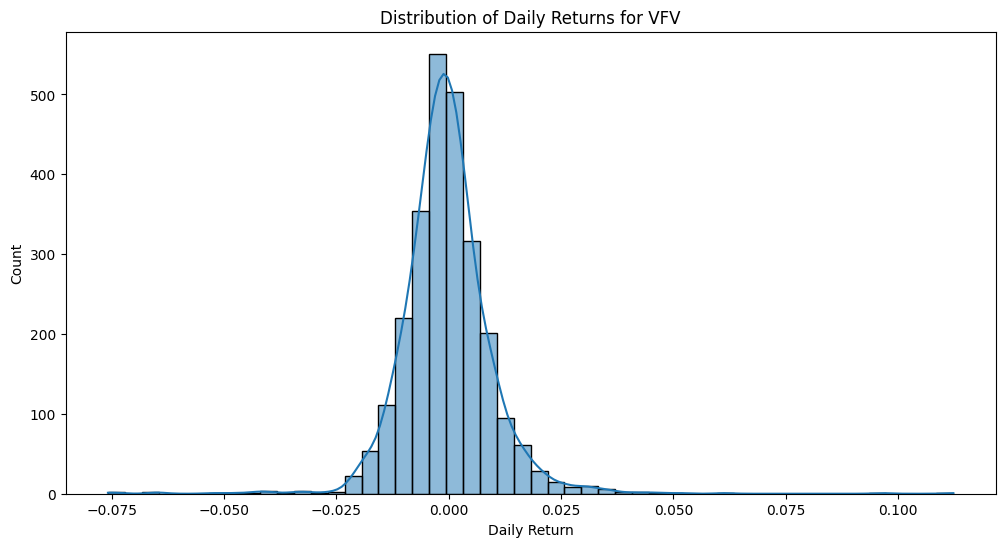

In [ ]:
# Visualize daily returns
plt.figure(figsize=(12, 6))
sns.histplot(vfv_data['Daily Return'].dropna(), bins=50, kde=True)
plt.title('Distribution of Daily Returns for VFV')
plt.show()

### Distribution of Daily Returns for VFV
- The distribution of daily returns looks fairly normal, centered around 0%, but with a slight skew.
- There are occasional outliers with larger positive and negative returns, indicating periods of higher volatility.
- The shape suggests most daily movements are small, but there are rare but significant jumps or drops — typical for equity investments.

In [ ]:
# Calculate moving averages
vfv_data['50_MA'] = vfv_data['Close'].rolling(window=50).mean()
vfv_data['200_MA'] = vfv_data['Close'].rolling(window=200).mean()
vfv_data

,NAV (CAD),Close,CADUSD,Daily Return,50_MA,200_MA
Date,,,,,,
2025-03-07,$147.2612,147.370,0.699736,NaN,NaN,NaN
2025-03-06,$145.8448,145.810,0.697418,-0.010586,NaN,NaN
2025-03-05,$148.8868,148.800,0.694584,0.020506,NaN,NaN
2025-03-04,$148.5961,148.600,0.690131,-0.001344,NaN,NaN
2025-03-03,$150.7359,150.700,0.692473,0.014132,NaN,NaN
...,...,...,...,...,...,...
2014-11-24,$41.5520,41.565,0.890456,0.003501,42.9037,45.654750
2014-11-21,$41.2651,41.245,0.884251,-0.007699,42.8191,45.631200
2014-11-20,$41.2772,41.285,0.881135,0.000970,42.7428,45.608725


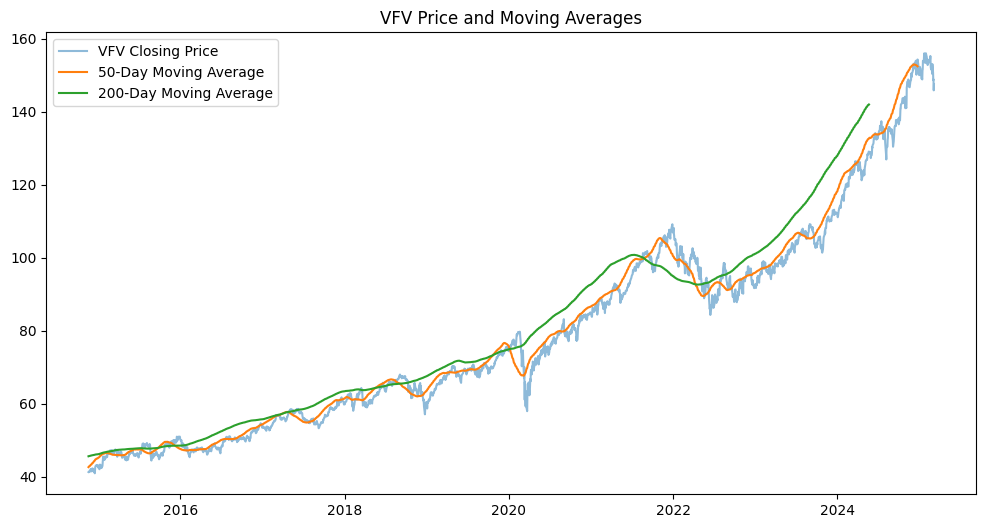

In [ ]:
# Visualize moving averages
plt.figure(figsize=(12, 6))
plt.plot(vfv_data.index, vfv_data['Close'], label='VFV Closing Price', alpha=0.5)
plt.plot(vfv_data.index, vfv_data['50_MA'], label='50-Day Moving Average')
plt.plot(vfv_data.index, vfv_data['200_MA'], label='200-Day Moving Average')
plt.legend()
plt.title('VFV Price and Moving Averages')
plt.show()

### VFV Price and Moving Averages
- The 50-day moving average (orange) tracks price movements more closely, capturing short-term trends.
- The 200-day moving average (green) reflects long-term momentum and smooths out volatility.
- Consistent upward movement with the 50-day above the 200-day most of the time suggests a strong bullish trend.
- Occasions where the 50-day crosses below the 200-day (like during early 2020) often signal periods of correction or increased risk.

## Overall Takeaways:
- VFV has shown strong long-term growth, though part of this may be influenced by a weakening CAD.
- There is some volatility in daily returns, but the distribution is mostly stable and normal.
- Moving averages suggest a strong upward trend, with occasional periods of correction.
- The combination of these trends highlights VFV’s potential as a solid long-term investment, but currency exchange rates should be considered when evaluating returns.